In [1]:
%load_ext autoreload
%autoreload 2

import fine_tune.train

/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segment Anything custom imported


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


In [2]:
cfg = None
dataset = None

In [3]:
import os
# set DATASET_DIRECTORY env var to "datasets/"
os.environ["DATASET_DIRECTORY"] = "datasets"

from fine_tune.configs.climbing import *

assert cfg is not None,"Must set config"
assert dataset is not None,"Must set training dataset"

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to datasets/Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 3757.21it/s]


In [4]:
import torch
seed = 5
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from fine_tune.load_datasets import load_datasets

train_dataset,valid_dataset = load_datasets(cfg.data,dataset)

Selecting classes ['climbing-holds', 'floor', 'person']


In [7]:
from fine_tune.models import WrappedSamModel

sam = WrappedSamModel(cfg).to(device)

encoder = sam.encoder
decoder = sam.decoder
predictor = sam.predictor

{}
warm started


In [8]:
import wandb
wandb.login()

True

In [9]:
import torch

run_num = None

if run_num is not None:
    sam.load_state_dict(torch.load(f"runs/{run_num}/trainable.pt"))

In [10]:
from fine_tune.load_datasets import prepare_torch_dataset

curr_dataset = prepare_torch_dataset(predictor,cfg,train_dataset,max_prompts=cfg.data.train_prompts)
valid_curr_dataset = prepare_torch_dataset(predictor,cfg,valid_dataset,max_prompts=cfg.data.valid_prompts)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 122910.01it/s]


In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
import numpy as np

from numpy.random import permutation
from tqdm import tqdm
import json

from fine_tune.common import SamDataset,get_max_iou_masks
from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt


In [12]:
from PIL import Image
import numpy as np

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0

    running_cls_loss = 0.0
    running_cls_count = 0

    for batch in tqdm(valid_curr_dataset):

        batch = SamDataset.to_device(batch,device)
        prompt_input, gt_info, gt_cls_info, imgs,sizes, prompt = batch

        use_cls = cfg.model.decoder.use_cls and gt_cls_info is not None

        with torch.no_grad():
            encoder_output = encoder.get_decoder_input(imgs,prompt)

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            _,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            normal_loss = losses["loss"]
            running_loss += normal_loss.item()
            running_count += 1

            cls_loss = losses["cls_loss"]
            running_cls_loss += cls_loss.item()
            running_cls_count += 1

            if use_cls:
                # get pred gt class
                (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)

                _,_,_,best_cls,_ = get_max_iou_masks(gt_info["masks"],cls_binary_masks,gt_cls_info["gt_cls"],torch.arange(cfg.data.num_classes).to(device))

                pred_classes.append(pred_cls)
                gt_classes.append(best_cls)

    valid_loss = running_loss/running_count
    valid_cls_loss = running_cls_loss/running_cls_count

    print(f"VALID - Base loss: {valid_loss:.4f} - Class loss: {valid_cls_loss:.4f}")

    wandb.log({
        "valid_normal_loss": valid_loss,
        "valid_cls_loss": valid_cls_loss,
    })

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [13]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 552803


100%|██████████| 200/200 [00:10<00:00, 19.58it/s]


VALID - Base loss: 0.8254 - Class loss: 1.5002


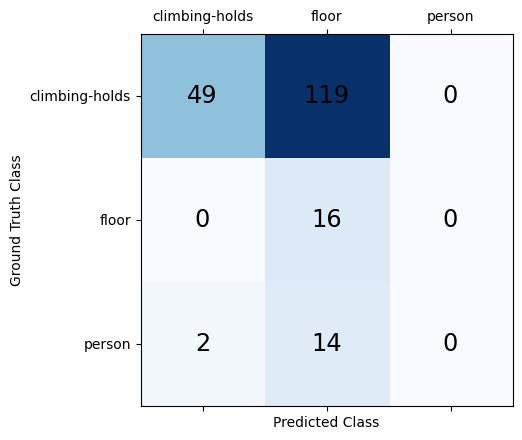

  0%|          | 2/6395 [00:00<10:29, 10.15it/s]

Loss: 1.2333087921142578


  3%|▎         | 203/6395 [00:12<05:24, 19.07it/s]

Loss: 1.412878967523575


  6%|▋         | 403/6395 [00:24<05:24, 18.48it/s]

Loss: 0.762279353775084


  9%|▉         | 603/6395 [00:35<05:06, 18.90it/s]

Loss: 0.5943600267916918


 13%|█▎        | 803/6395 [00:47<04:50, 19.23it/s]

Loss: 0.49013965668156745


 16%|█▌        | 1003/6395 [00:58<04:54, 18.30it/s]

Loss: 0.7099793260730803


 19%|█▉        | 1204/6395 [01:10<04:35, 18.82it/s]

Loss: 0.36888789348304274


 22%|██▏       | 1403/6395 [01:21<04:32, 18.31it/s]

Loss: 0.4847181339934468


 25%|██▌       | 1603/6395 [01:33<04:14, 18.80it/s]

Loss: 0.4394999935105443


 28%|██▊       | 1803/6395 [01:44<04:05, 18.72it/s]

Loss: 0.37853138986974955


 31%|███▏      | 2003/6395 [01:55<03:55, 18.61it/s]

Loss: 0.37147549984976647


 34%|███▍      | 2203/6395 [02:07<03:32, 19.72it/s]

Loss: 0.3424126361683011


 38%|███▊      | 2404/6395 [02:18<03:33, 18.66it/s]

Loss: 0.3798636757582426


 41%|████      | 2603/6395 [02:30<03:33, 17.79it/s]

Loss: 0.4070369074679911


 44%|████▍     | 2803/6395 [02:41<03:10, 18.88it/s]

Loss: 0.4467838121578097


 47%|████▋     | 3003/6395 [02:52<02:59, 18.85it/s]

Loss: 0.4086313652805984


 50%|█████     | 3203/6395 [03:04<02:53, 18.41it/s]

Loss: 0.38002201749011877


 53%|█████▎    | 3404/6395 [03:15<03:01, 16.50it/s]

Loss: 0.44160395927727225


 56%|█████▋    | 3603/6395 [03:27<02:31, 18.46it/s]

Loss: 0.4248787833377719


 59%|█████▉    | 3804/6395 [03:38<02:12, 19.51it/s]

Loss: 0.39897430915385484


 63%|██████▎   | 4004/6395 [03:50<02:43, 14.64it/s]

Loss: 0.3661106892675161


 66%|██████▌   | 4204/6395 [04:01<02:02, 17.84it/s]

Loss: 0.29730718506500126


 69%|██████▉   | 4403/6395 [04:13<01:42, 19.38it/s]

Loss: 0.34489764999598266


 72%|███████▏  | 4603/6395 [04:24<01:36, 18.55it/s]

Loss: 0.37981513561680913


 75%|███████▌  | 4803/6395 [04:35<01:30, 17.53it/s]

Loss: 0.3082519298233092


 78%|███████▊  | 5003/6395 [04:47<01:13, 18.91it/s]

Loss: 0.40479141774587335


 81%|████████▏ | 5202/6395 [04:58<01:12, 16.52it/s]

Loss: 0.3487859960086644


 84%|████████▍ | 5403/6395 [05:10<00:52, 19.00it/s]

Loss: 0.25715143540874125


 88%|████████▊ | 5603/6395 [05:21<00:42, 18.53it/s]

Loss: 0.29563155692070725


 91%|█████████ | 5802/6395 [05:32<00:34, 17.13it/s]

Loss: 0.380862479172647


 94%|█████████▍| 6003/6395 [05:44<00:21, 18.48it/s]

Loss: 0.28848473692312837


 97%|█████████▋| 6202/6395 [05:55<00:11, 17.53it/s]

Loss: 0.3427937293238938


100%|██████████| 6395/6395 [06:06<00:00, 17.43it/s]


In [14]:
from dataclasses import asdict

run = wandb.init(
    project="sam-fine-tune",
    config=asdict(cfg)
)

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []

curr_epoch = 0

# iter through dataset in random order
while curr_iters < cfg.train.max_steps:
    evaluate()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        with torch.no_grad():
            prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = SamDataset.to_device(curr_dataset[idx],device)
        
        use_cls_loss = gt_cls_info is not None and cfg.model.decoder.use_cls
        
        has_fresh_prompt = True
        refinements_remaining = cfg.train.num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            encoder_output = encoder.get_decoder_input(imgs,prompt)
            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)


            #
            # WandB
            #
            
            loss,loss_dict = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            input_img_torch = imgs[2]
            image_embeddings= encoder_output["image_embeddings"]

            loss_dict = {k:v.item() for k,v in loss_dict.items()}
            wandb.log(loss_dict)

            #
            # Logging
            #

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-cfg.train.log_period:]

            if curr_iters % cfg.train.eval_period == 0:
                pass

            if curr_iters % cfg.train.log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            curr_iters += 1

            if not cfg.train.run_grad: continue

            accumulated_loss += loss
            if curr_iters % cfg.train.batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(cfg.train.batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0
            
            scheduler.step()

            #
            # Progressive refinement
            #

            if refinements_remaining > 0:

                raise NotImplementedError("Need to update this to use new training system")

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

In [15]:
from glob import glob
import os

runs_dir = "runs_new"
run_ids = [int(fname) for fname in os.listdir(runs_dir)]
highest_run = max(run_ids) if len(run_ids) > 0 else 0
run_num = highest_run + 1
export_dir = f"{runs_dir}/{run_num}"
!mkdir -p $export_dir
print(f"Run saved to {export_dir}")

from fine_tune.export import export

export(export_dir,cfg,sam)

Run saved to runs_new/12


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:08<00:00, 23.83it/s]


VALID - Base loss: 0.8254 - Class loss: 0.3407


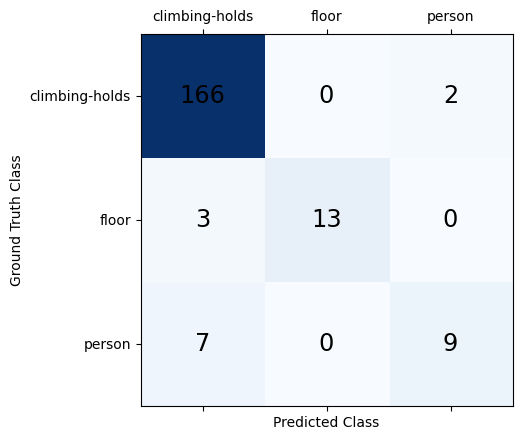

In [16]:
evaluate()

Loss: 0.5017433166503906
Predicted IoU: 0.6913070678710938 real IoU: 0.31372833251953125


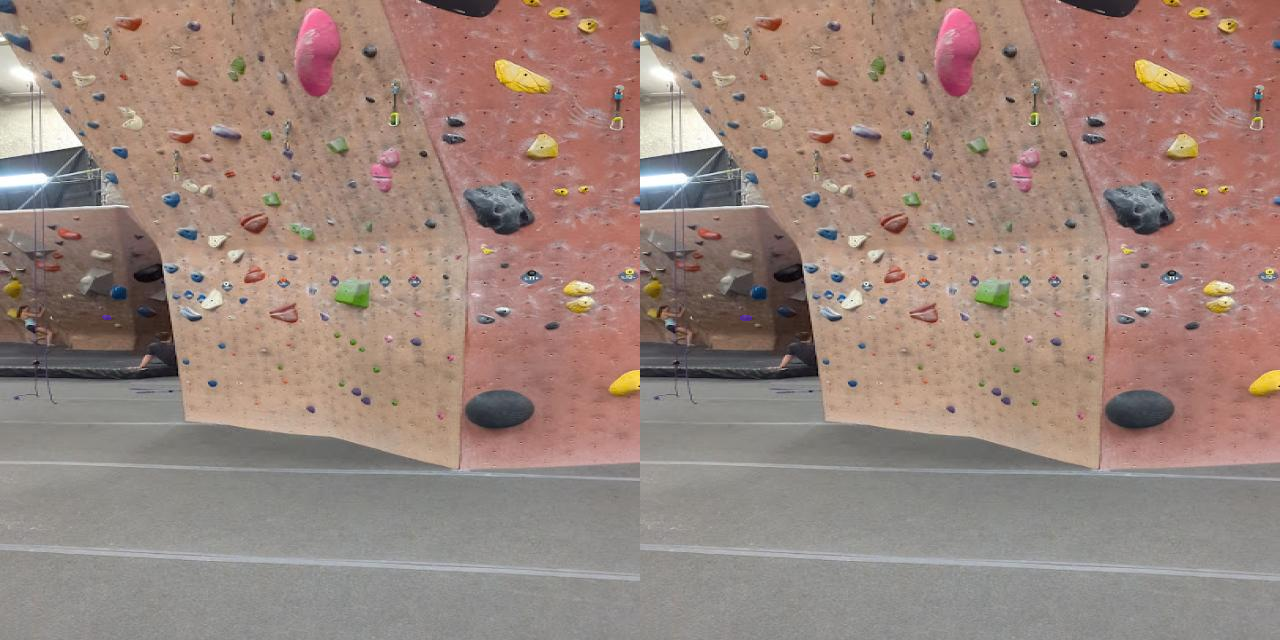

Cls loss: 0.18022529780864716
Predicted cls: 0 GT cls: 0
Predicted cls IoU: 0.6913070678710938 real cls IoU: 0.31372833251953125


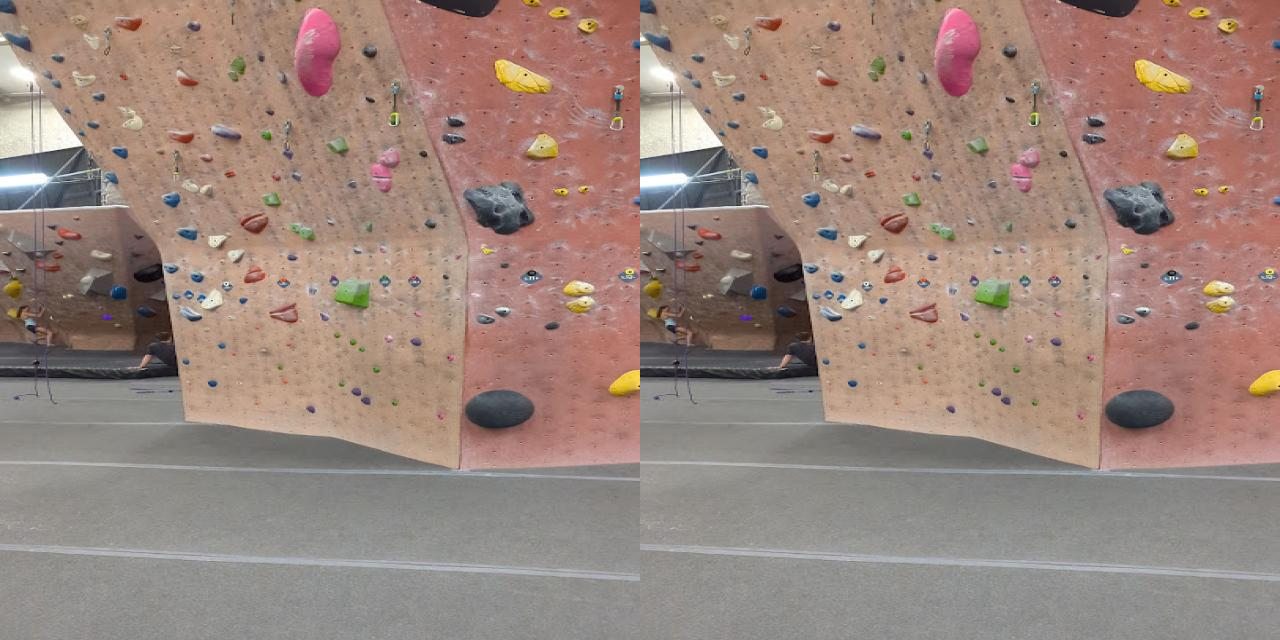

In [17]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = SamDataset.to_device(v_c_ds[idx],device)

gt_masks = gt_info["masks"]
gt_cls = gt_cls_info["gt_cls"]

use_normal_tokens = True
use_cls_tokens = cfg.model.decoder.use_cls and gt_cls_info is not None

has_fresh_prompt = True
num_refinements_left = cfg.train.num_refinement_steps
while has_fresh_prompt:
    has_fresh_prompt = False

    with torch.no_grad():
        encoder_output = encoder.get_decoder_input(imgs,prompt)
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

        loss,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
        
        (upscaled_masks,binary_masks),max_idx = decoder.postprocess(low_res_masks,iou_predictions,sizes)
        pred_iou = F.sigmoid(iou_predictions[0,max_idx]).item()
        binary_mask = binary_masks[max_idx]

        gt_binary_mask, _, _, _, _ = get_max_iou_masks(gt_masks,binary_mask[None,...])

        if use_cls_tokens:

            (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)
            cls_binary_mask = cls_binary_masks[pred_cls,...]

            # get focal and dice loss between cls_binary_mask and closest gt mask
            cls_gt_binary_mask,_,max_iou,best_cls,_ = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(cfg.data.num_classes).to(device))

        if num_refinements_left > 0:
            raise NotImplementedError("Need to update this to use new training system")

            has_fresh_prompt = True
            num_refinements_left -= 1

from PIL import Image

img = imgs[0]

if use_normal_tokens:
    print("Loss:",losses["loss"].item())
    print("Predicted IoU:",pred_iou,"real IoU:",max_iou.item())

    clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

# print cls loss
if use_cls_tokens:
    print("Cls loss:",losses["cls_loss"].item())
    print("Predicted cls:",pred_cls.item(),"GT cls:",gt_cls.item())
    print("Predicted cls IoU:",pred_iou,"real cls IoU:",max_iou.item())

    clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

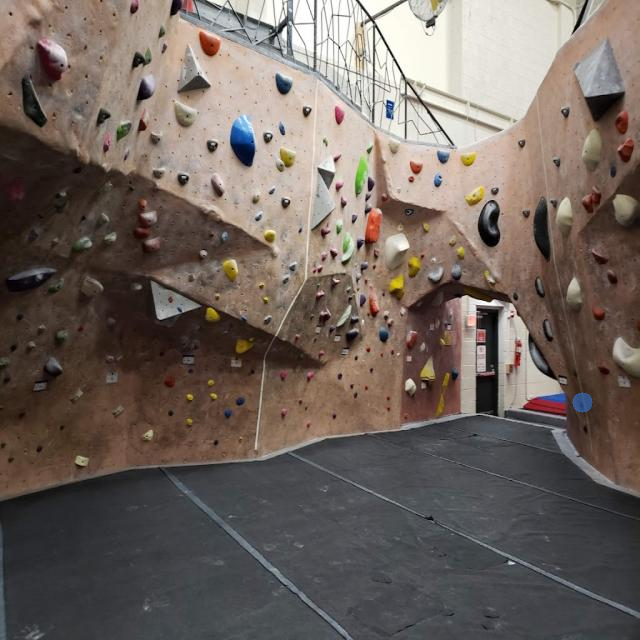

In [18]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
render_prompt(name,prompt,train_dataset)